**Importing Libraries**

In [1]:
import numpy as np
import os
from os.path import isfile
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Dense, TimeDistributed, LSTM, Dropout, Activation
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda
from keras.layers.advanced_activations import ELU
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
import librosa
import librosa.display
import matplotlib.pyplot as plt
import random
import numpy as np
np.random.seed(1001)
import os
import shutil
import IPython
import seaborn as sns
from scipy.io import wavfile
from tqdm import tqdm_notebook 
import IPython.display as ipd
import librosa
import numpy as np
import scipy
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras.layers import (Convolution1D, Dense, Dropout, GlobalAveragePooling1D, 
                          GlobalMaxPool1D, Input, MaxPool1D, concatenate)
from keras.utils import Sequence, to_categorical
from keras.layers import (Convolution2D, GlobalAveragePooling2D, BatchNormalization, Flatten,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation)
from keras.utils import Sequence, to_categorical
from keras import backend as K

Using TensorFlow backend.


In [2]:
train_folder = '../input/midasemotions/meld/train/'
val_folder = '../input/midasemotions/meld/val/'

In [3]:
test_folder = ''

**Visualizations**

Sampling (frame) rate =  16000
Total samples (frames) =  (64853, 2)


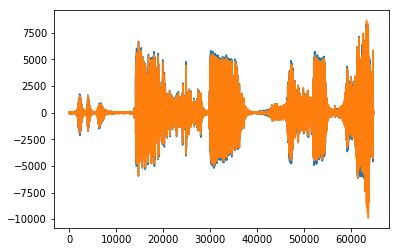

In [4]:
wav_files = os.listdir(train_folder+'happy/')
index = random.randint(0, len(wav_files)-1)
fname = train_folder+'happy/'+wav_files[index]
rate, data = wavfile.read(fname)
print("Sampling (frame) rate = ", rate)
print("Total samples (frames) = ", data.shape)
plt.plot(data, '-', )


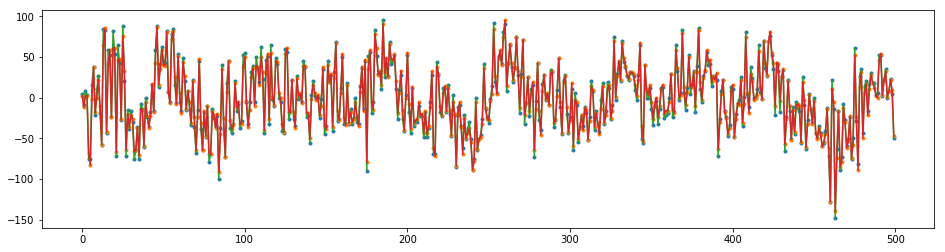

In [5]:
plt.figure(figsize=(16, 4))
plt.plot(data[:500], '.'); plt.plot(data[:500], '-');

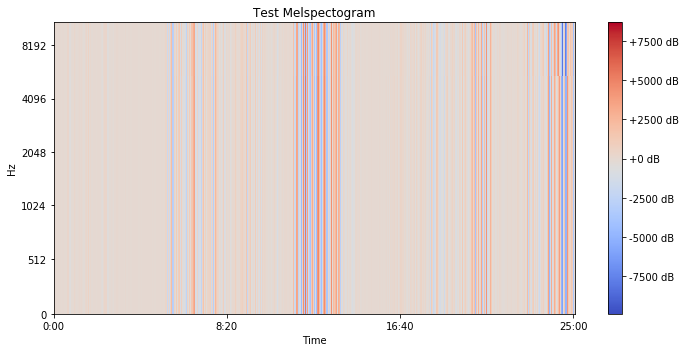

In [7]:
plt.figure(figsize=(10, 5))
librosa.display.specshow(data.T, y_axis='mel', x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Test Melspectogram')
plt.tight_layout()

**Mapping of given emotions to constants**

In [8]:
emotions = {'happy':0, 'sad':1, 'disgust':2, 'neutral':3, 
               'fear':4}


reverse_emotions = {v: k for k, v in emotions.items()}
print(reverse_emotions)

{0: 'happy', 1: 'sad', 2: 'disgust', 3: 'neutral', 4: 'fear'}


In [9]:
class Config(object):
    def __init__(self,
                 sampling_rate=16000, audio_duration=2, n_classes=41,
                 use_mfcc=False, n_folds=10, learning_rate=0.0001, 
                 max_epochs=50, n_mfcc=20):
        self.sampling_rate = sampling_rate
        self.audio_duration = audio_duration
        self.n_classes = n_classes
        self.use_mfcc = use_mfcc
        self.n_mfcc = n_mfcc
        self.n_folds = n_folds
        self.learning_rate = learning_rate
        self.max_epochs = max_epochs

        self.audio_length = self.sampling_rate * self.audio_duration
        if self.use_mfcc:
            self.dim = (self.n_mfcc, 1 + int(np.floor(self.audio_length/512)), 1)
        else:
            self.dim = (self.audio_length, 1)

**Normalization Function**

In [10]:
def audio_norm(data):
    max_data = np.max(data)
    min_data = np.min(data)
    data = (data-min_data)/(max_data-min_data+1e-6)
    return data-0.5

**Lists for storing features corresponding to .wav files and the corresponding labels**

In [11]:
X=[]
Y=[]

**Function for populating training data**

In [12]:
def prepare_train_data( config, data_dir):
   # X = np.empty(shape=(size, config.dim[0], config.dim[1], 1))
   # Y = np.zeros(shape = (size,5))
   # print(X.shape)
    input_length = config.audio_length
    index = 0
    for emotion_dir in os.listdir(data_dir):
        label = emotion_dir
        audio_dir = data_dir+ emotion_dir
        count  = 0
        if label == 'neutral':
            count = 0
        elif label == 'happy':
            count = 3
        else :
            count = 15
        for file in os.listdir(audio_dir):
            
            file_path = audio_dir+'//' + file
            data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
            
            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
            d = data
            data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
            data = np.expand_dims(data, axis=-1)
            #X[index,] = data
            X.append(data)
            l = emotions[label]
            #Y[index][l] = 1
            z= np.zeros(5)
            z[l]=1
            Y.append(z)
            #print(Y[index])
            #print(index)
            #index+=1
            noise_examples = count/3 
            while noise_examples :
                noise_factor = random.randint(0,10)%100
                noise = np.random.randn(len(d))
                augmented_data = d + noise_factor * noise
                data = augmented_data
                if len(data) > input_length:
                    max_offset = len(data) - input_length
                    offset = np.random.randint(max_offset)
                    data = data[offset:(input_length+offset)]
                else:
                    if input_length > len(data):
                        max_offset = input_length - len(data)
                        offset = np.random.randint(max_offset)
                    else:
                        offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                data = librosa.feature.mfcc(augmented_data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
                X.append(data)
                Y.append(z)
                noise_examples-=1
             
            pitch_examples = count/3 
            while pitch_examples : 
                    pitch_factor = random.randint(0, 20)/10
                    data = librosa.effects.pitch_shift(d, config.sampling_rate, pitch_factor)
                    if len(data) > input_length:
                        max_offset = len(data) - input_length
                        offset = np.random.randint(max_offset)
                        data = data[offset:(input_length+offset)]
                    else:
                        if input_length > len(data):
                            max_offset = input_length - len(data)
                            offset = np.random.randint(max_offset)
                        else:
                            offset = 0
                        data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                    data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
                    data = np.expand_dims(data, axis=-1)
                    X.append(data)
                    Y.append(z)
                    pitch_examples -= 1
             
            time_examples = count/3  
            while time_examples :
                speed_factor =random.randint(1,2)
                data = librosa.effects.time_stretch(d, speed_factor)
                if len(data) > input_length:
                    max_offset = len(data) - input_length
                    offset = np.random.randint(max_offset)
                    data = data[offset:(input_length+offset)]
                else:
                    if input_length > len(data):
                        max_offset = input_length - len(data)
                        offset = np.random.randint(max_offset)
                    else:
                        offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
                data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
                data = np.expand_dims(data, axis=-1)
                X.append(data)
                Y.append(z)
                #print(Y[len(Y)-1])
                time_examples -= 1  
            print(X[len(X)-1].shape)    
    return X,Y

**Function for populating validation data**

> Due to non-uniform distribution of audio files corresponding to a given label, I have chosen to apply data augmentation which mainly includes mainly includes the following methods:
>1. Noise Injection
>2. Changing Pitch
>3. Changing Speed

In [13]:
def prepare_val_data( config, data_dir,size):
    X = np.empty(shape=(size, config.dim[0], config.dim[1], 1))
    Y = np.zeros(shape = (size,5))
    print(X.shape)
    input_length = config.audio_length
    index = 0
    for emotion_dir in os.listdir(data_dir):
        label = emotion_dir
        audio_dir = data_dir+ emotion_dir
        for file in os.listdir(audio_dir):
            file_path = audio_dir+'//' + file
            data, _ = librosa.core.load(file_path, sr=config.sampling_rate, res_type="kaiser_fast")
            
            # Random offset / Padding
            if len(data) > input_length:
                max_offset = len(data) - input_length
                offset = np.random.randint(max_offset)
                data = data[offset:(input_length+offset)]
            else:
                if input_length > len(data):
                    max_offset = input_length - len(data)
                    offset = np.random.randint(max_offset)
                else:
                    offset = 0
                data = np.pad(data, (offset, input_length - len(data) - offset), "constant")
            d = data
            data = librosa.feature.mfcc(data, sr=config.sampling_rate, n_mfcc=config.n_mfcc)
            data = np.expand_dims(data, axis=-1)
            X[index,] = data
            l = emotions[label]
            Y[index][l] = 1
    print('Done')        
    return X,Y       

In [14]:
config = Config(sampling_rate=16000, audio_duration=1, n_folds=10, 
                learning_rate=0.0001, use_mfcc=True, n_mfcc=40)

In [15]:
 prepare_train_data(config,train_folder)

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40, 32, 1)
(40,

([array([[[-293.07446   ],
          [-311.18698   ],
          [-327.00684   ],
          ...,
          [-114.13225   ],
          [-107.0868    ],
          [-103.527885  ]],
  
         [[ 176.096     ],
          [ 173.06796   ],
          [ 152.52328   ],
          ...,
          [  97.66119   ],
          [  95.46328   ],
          [  95.99319   ]],
  
         [[  20.246208  ],
          [  19.537914  ],
          [  31.261953  ],
          ...,
          [ -48.801014  ],
          [ -39.90177   ],
          [ -33.625095  ]],
  
         ...,
  
         [[   1.1499991 ],
          [  -1.9128554 ],
          [  -7.1066628 ],
          ...,
          [   4.743455  ],
          [  -0.49778014],
          [  -7.143885  ]],
  
         [[  -3.6114728 ],
          [  -3.0539265 ],
          [  -4.0394673 ],
          ...,
          [   2.3313122 ],
          [  -0.9281815 ],
          [  -2.297097  ]],
  
         [[  -5.219132  ],
          [  -4.368101  ],
          [  -2.9454339 

In [16]:
len(X)

29476

In [18]:
Xval , Yval = prepare_val_data(config,val_folder,830)

(830, 40, 32, 1)
Done


In [19]:
Y_train = np.asarray(Y)

In [20]:
X_train = np.asarray(X)

In [21]:
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)
X_train = (X_train - mean)/std


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
Xtrain, Xval, Ytrain, Yval =train_test_split(X_train,Y_train,test_size=0.2)

In [22]:
mean = np.mean(Xval, axis=0)
std = np.std(Xval, axis=0)
Xval = (Xval - mean)/std

/opt/conda/lib/python3.6/site-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


**Model Definiton and Architecture**

In [23]:
def get_2d_dummy_model(config):
    
    nclass = config.n_classes
    
    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = GlobalMaxPool2D()(inp)
    out = Dense(nclass, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model


def get_2d_conv_model(config):

    inp = Input(shape=(config.dim[0],config.dim[1],1))
    x = Convolution2D(32, (3,3), padding="same")(inp)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(64, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(128, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)
    
    x = Convolution2D(256, (3,3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPool2D()(x)

    x = Flatten()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    out = Dense(5, activation=softmax)(x)

    model = models.Model(inputs=inp, outputs=out)
    opt = optimizers.Adam(config.learning_rate)

    model.compile(optimizer=opt, loss=losses.categorical_crossentropy, metrics=['acc'])
    return model

In [24]:
model = get_2d_conv_model(config)
    

In [25]:
print(model.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 32, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 32, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 40, 32, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 40, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 20, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 20, 16, 64)        256 

In [ ]:
from sklearn.utils import shuffle
X_train, Y_train =shuffle(X_train, Y_train, random_state=0)
Xval, Yval =shuffle(Xval,Yval,random_state = 0)

In [ ]:
history = model.fit(X_train, Y_train, validation_data=(Xval, Yval), epochs=10)

Train on 29476 samples, validate on 830 samples
Epoch 1/10
29476/29476 [==============================] - 16s 558us/step - loss: 1.3246 - acc: 0.4476 - val_loss: 0.0106 - val_acc: 0.0000e+00
Epoch 2/10
29476/29476 [==============================] - 11s 373us/step - loss: 0.9805 - acc: 0.6249 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 3/10
29476/29476 [==============================] - 11s 375us/step - loss: 0.7487 - acc: 0.7285 - val_loss: 0.0109 - val_acc: 1.0000
Epoch 4/10
29476/29476 [==============================] - 11s 375us/step - loss: 0.5957 - acc: 0.7885 - val_loss: 0.0110 - val_acc: 1.0000
Epoch 5/10
29476/29476 [==============================] - 11s 381us/step - loss: 0.4891 - acc: 0.8286 - val_loss: 0.0119 - val_acc: 1.0000
Epoch 6/10
29476/29476 [==============================] - 11s 376us/step - loss: 0.4195 - acc: 0.8515 - val_loss: 0.0112 - val_acc: 1.0000
Epoch 7/10
29476/29476 [==============================] - 11s 374us/step - loss: 0.3729 - acc: 0.8644 - val_loss: 

In [ ]:
plt.plot(history.history['loss']) 